# Exploring the dataset

In [1]:
import pandas as pd
import json
import os

In [2]:
# create a csv file for all codes (labels) 
all_df = pd.DataFrame()
path = 'C:\\Users\\user\\Desktop\\AI projects\\nlp_project_files\\'
for file in os.listdir(r'C:\Users\user\Desktop\AI projects\nlp_project_files'):
    if  file != 'kone_classification.json':
        df = pd.read_csv(f'{path}{file}')
        all_df = pd.concat([all_df, df], ignore_index=True)

print(all_df.shape)
all_df.to_csv(f'{path}complete_codes.csv')

(134, 13)


In [3]:
# open the jesonfile as dataframe
json_file = "C:\\Users\\user\\Desktop\\AI projects\\nlp_project_files\\kone_classification.json"
with open(json_file) as f:
    data = json.load(f)
    df_json=pd.DataFrame(data)

In [4]:
df_json.head(15)

,text,label,culture,document_id,annotation_id,source
0,"Eclairage de la gaine , à compléter rappel : 2",SH16,fr-fr,62baee150c69f839d30f8f65,62b2f92cc0979ee09ccce7ab,TRAINING
1,Contacten elektrische motor van de deurkooiope...,CAR06,nl-nl,61c32860a4661f0482909b48,628cf0e291fca41ccdd01599,WORKFLOW
2,"Les zone de porte ne fonctionne pas , y remédier",CD06,fr-fr,62ac68067852a3302e3c52a1,62ac68437852a30ec93c53cd,WORKFLOW
3,Enlever les autocollants STALIFT,OTHER,fr-fr,624444fbb81db03e43beb09f,626a81e78e6b09e818279c6c,WORKFLOW
4,Le boitier métallique sur le toit de cabine es...,CAR23,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bddbcb5dabb0b76331e9,TRAINING
5,Plaque d ' identification n ' est pas complète...,CAR26,fr-fr,626a83cbb9856f0321a63cf0,626a83a48e6b09e818279c76,TRAINING
6,Le bon fonctionnement du système appel de seco...,CAR01,fr-fr,6267d3d51fcf59b6b53377cd,6267a1795b5251e0ea710021,TRAINING
7,Liftkooi : De noodverlichting brandt permanent...,LD05,fr-fr,62c2d75f8ac2d71881973774,62c2d780c3ec0414933c5bf7,WORKFLOW
8,Les données du propriétaire sont à placer en c...,CAR06,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bdb0cb5dabb0b76331e6,TRAINING
9,Il manque l ' attestation de régularisation da...,DOC01,fr-fr,62b99d1ebe6767de2795021d,62b99dfebe6767ed089516c5,WORKFLOW


In [5]:
print("The description of the dataset is: \n",df_json.describe())
print("The number of labels in the dataset is: ",df_json['label'].nunique())
# count the rows for each language
df_json.groupby('culture').count()

The description of the dataset is: 
                                                      text  label culture  \
count                                                 525    525     525   
unique                                                188     56       2   
top     Les données du propriétaire sont à placer en c...  OTHER   fr-fr   
freq                                                   16     63     497   

                     document_id             annotation_id    source  
count                        525                       525       525  
unique                       169                       210         2  
top     626a83cab9856f460ea61d18  62b2f92cc0979ee09ccce7ab  WORKFLOW  
freq                          13                         4       278  
The number of labels in the dataset is:  56


,text,label,document_id,annotation_id,source
culture,,,,,
fr-fr,497,497,497,497,497
nl-nl,28,28,28,28,28


In [109]:
# check the maximum and minimum frequent for each label
df_json.groupby('label').count().sort_values(by=['text'], ascending=False)

,text,culture,document_id,annotation_id,source
label,,,,,
OTHER,63,63,63,63,63
DOC02,60,60,60,60,60
CAR06,34,34,34,34,34
DOC01,29,29,29,29,29
CAR02,28,28,28,28,28
SH01,21,21,21,21,21
CAR01,20,20,20,20,20
MR08,18,18,18,18,18
MR16,16,16,16,16,16


In [7]:
# choose the training source and drop the workflow
df_json_training= df_json.loc[df_json['source']== 'TRAINING',:]
df_json_training

,text,label,culture,document_id,annotation_id,source
0,"Eclairage de la gaine , à compléter rappel : 2",SH16,fr-fr,62baee150c69f839d30f8f65,62b2f92cc0979ee09ccce7ab,TRAINING
4,Le boitier métallique sur le toit de cabine es...,CAR23,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bddbcb5dabb0b76331e9,TRAINING
5,Plaque d ' identification n ' est pas complète...,CAR26,fr-fr,626a83cbb9856f0321a63cf0,626a83a48e6b09e818279c76,TRAINING
6,Le bon fonctionnement du système appel de seco...,CAR01,fr-fr,6267d3d51fcf59b6b53377cd,6267a1795b5251e0ea710021,TRAINING
8,Les données du propriétaire sont à placer en c...,CAR06,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bdb0cb5dabb0b76331e6,TRAINING
...,...,...,...,...,...,...
517,Dossier de sécurité : le rapport d ' analyse d...,DOC02,fr-fr,6267e4641fcf5985433b28b0,6267d68933387bce1ed044de,TRAINING
518,La vitre de la boîte à clé est absente .,CAR19,fr-fr,62b59bc0e91a4e221daa16e6,62b59b5815361571248badce,TRAINING
519,Nettoyer la cuvette 1 e Répétition,SH01,fr-fr,626a85c8b9856f4085a7b987,626a84bd8e6b09e818279c7a,TRAINING
523,Veuillez fixer les 3 poids dont la taille ne p...,CW01,fr-fr,62b1beeb0e2b733fd8648381,62b1bcbecb5dabb0b76331e3,TRAINING


In [8]:
# find the duplicated rows
duplicateRows = df_json_training[df_json_training.duplicated()]


In [9]:
# drop duplicated rows
df_json_training.drop_duplicates()

,text,label,culture,document_id,annotation_id,source
0,"Eclairage de la gaine , à compléter rappel : 2",SH16,fr-fr,62baee150c69f839d30f8f65,62b2f92cc0979ee09ccce7ab,TRAINING
4,Le boitier métallique sur le toit de cabine es...,CAR23,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bddbcb5dabb0b76331e9,TRAINING
5,Plaque d ' identification n ' est pas complète...,CAR26,fr-fr,626a83cbb9856f0321a63cf0,626a83a48e6b09e818279c76,TRAINING
6,Le bon fonctionnement du système appel de seco...,CAR01,fr-fr,6267d3d51fcf59b6b53377cd,6267a1795b5251e0ea710021,TRAINING
8,Les données du propriétaire sont à placer en c...,CAR06,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bdb0cb5dabb0b76331e6,TRAINING
...,...,...,...,...,...,...
517,Dossier de sécurité : le rapport d ' analyse d...,DOC02,fr-fr,6267e4641fcf5985433b28b0,6267d68933387bce1ed044de,TRAINING
518,La vitre de la boîte à clé est absente .,CAR19,fr-fr,62b59bc0e91a4e221daa16e6,62b59b5815361571248badce,TRAINING
519,Nettoyer la cuvette 1 e Répétition,SH01,fr-fr,626a85c8b9856f4085a7b987,626a84bd8e6b09e818279c7a,TRAINING
523,Veuillez fixer les 3 poids dont la taille ne p...,CW01,fr-fr,62b1beeb0e2b733fd8648381,62b1bcbecb5dabb0b76331e3,TRAINING


In [10]:
# choose the French culture
df_json_training_fr = df_json_training.loc[df_json_training['culture']=='fr-fr',:]

In [11]:
print(df_json_training_fr['document_id'].nunique())
print(df_json_training_fr['annotation_id'].nunique())
# check how many unique labels are there
print('the unique number of labels is: ',df_json_training_fr['label'].nunique())

75
182
the unique number of labels is:  50


In [112]:
# check the maximum and minimum frequent for each label
df_json_training_fr.groupby('label').count().sort_values(by=['text'], ascending=False)

,text,culture,document_id,annotation_id,source
label,,,,,
OTHER,31,31,31,31,31
DOC02,29,29,29,29,29
CAR06,16,16,16,16,16
DOC01,14,14,14,14,14
CAR02,13,13,13,13,13
SH01,10,10,10,10,10
MR08,9,9,9,9,9
MR16,8,8,8,8,8
SH11,8,8,8,8,8


# Preprosessing the text data


In [86]:

import re

# some text cleaning functions
def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_special_char(text):
    special_char = r'[^\w\s]|.:,*"'
    remove_special_char = re.sub(pattern=special_char, repl=" ", string=text)
    return remove_special_char
df_json['text'] = df_json['text'].apply(lambda x: convert_to_lower(x))
df_json['text'] = df_json['text'].apply(lambda x: remove_numbers(x))
df_json['text'] = df_json['text'].apply(lambda x: remove_extra_white_spaces(x))
df_json['text'] = df_json['text'].apply(lambda x: remove_special_char(x))

In [ ]:
df_json_training_fr['text'] = df_json_training_fr['text'].apply(lambda x: convert_to_lower(x))
df_json_training_fr['text'] = df_json_training_fr['text'].apply(lambda x: remove_numbers(x))
df_json_training_fr['text'] = df_json_training_fr['text'].apply(lambda x: remove_extra_white_spaces(x))
df_json_training_fr['text'] = df_json_training_fr['text'].apply(lambda x: remove_special_char(x))

------------------------------------------------------------------------------------------------------------------------------------------------------------

## implement ML classification

In [88]:
# copy the dataframe to start working on the first example https://www.analyticsvidhya.com/blog/2021/11/a-guide-to-building-an-end-to-end-multiclass-text-classification-model/
df = df_json_training_fr.copy()
# Create a new column 'category_id' with encoded categories 
df['category_id'] = df['label'].factorize()[0]

In [89]:
category_id_df = df[['label', 'category_id']]

In [90]:
category_id_df

,label,category_id
0,SH16,0
4,CAR23,1
5,CAR26,2
6,CAR01,3
8,CAR06,4
...,...,...
517,DOC02,7
518,CAR19,48
519,SH01,21
523,CW01,49


In [91]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
# New dataframe
df.head()

,text,label,culture,document_id,annotation_id,source,category_id
0,eclairage de la gaine à compléter rappel,SH16,fr-fr,62baee150c69f839d30f8f65,62b2f92cc0979ee09ccce7ab,TRAINING,0
4,le boitier métallique sur le toit de cabine es...,CAR23,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bddbcb5dabb0b76331e9,TRAINING,1
5,plaque identification est pas complète ou est ...,CAR26,fr-fr,626a83cbb9856f0321a63cf0,626a83a48e6b09e818279c76,TRAINING,2
6,le bon fonctionnement du système appel de seco...,CAR01,fr-fr,6267d3d51fcf59b6b53377cd,6267a1795b5251e0ea710021,TRAINING,3
8,les données du propriétaire sont à placer en c...,CAR06,fr-fr,62b1beee0e2b73b9d964e1e5,62b1bdb0cb5dabb0b76331e6,TRAINING,4


Text(0.5, 0, 'Number of ocurrences')

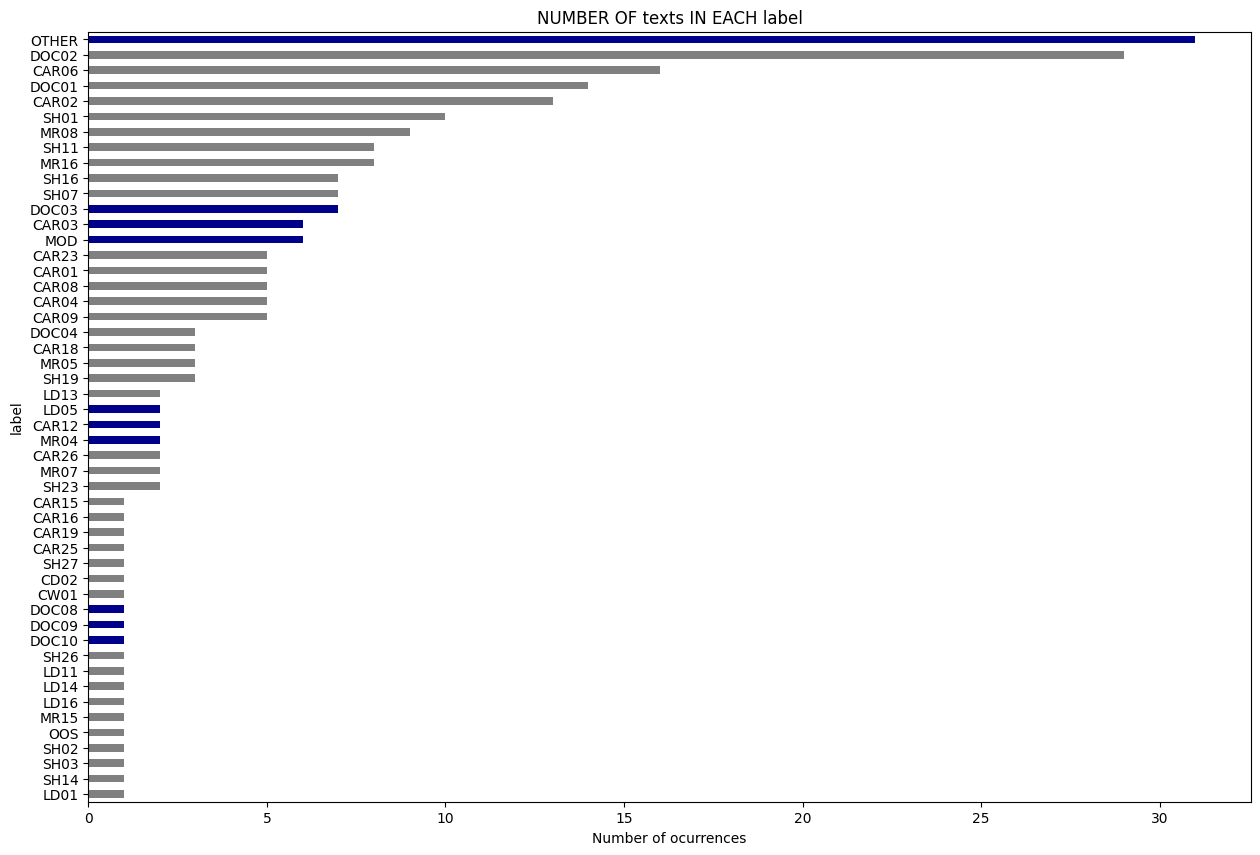

In [92]:
import matplotlib.pyplot as plt

# visualize the data, and see how many numbers of text are there per label

fig = plt.figure(figsize=(15,10))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF texts IN EACH label')
plt.xlabel('Number of ocurrences', fontsize = 10)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

final_stopwords_list = list(fr_stop) 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words=final_stopwords_list)
# We transform each complaint into a vector
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 242 text is represented by 176 features (TF-IDF score of unigrams and bigrams)


c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(


In [94]:
labels.unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int64)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

# Finding the three most correlated terms with each of the labels
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

In [96]:

from sklearn.model_selection import train_test_split
X = df['text'] # Collection of documents
y = df['category_id'] # Target or the labels we want to predict (i.e., the 50 different label)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [98]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [99]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [100]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.752211,0.023158
LogisticRegression,0.632228,0.016755
MultinomialNB,0.537075,0.039198
RandomForestClassifier,0.512585,0.030646


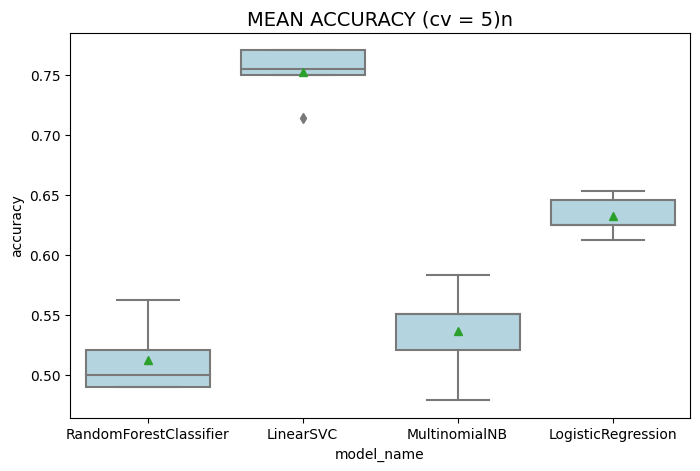

In [101]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

In [102]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [103]:
y_pred

array([11, 34,  8, 13, 28,  9, 18,  8, 18,  4,  9, 21,  6, 38,  7, 21, 22,
       22, 11, 18,  0,  7, 11,  7, 17,  7, 21,  6,  1,  9,  9,  8,  9,  9,
       38,  3, 18,  4, 12,  9,  6,  7,  7,  7,  9, 20,  7,  0, 13,  0,  9,
        9,  8, 21,  6, 13, 33,  9,  7, 17,  7], dtype=int64)

In [104]:
# Classification report
print('ttttCLASSIFICATIION METRICSn')
print(metrics.classification_report(y_test, y_pred))

ttttCLASSIFICATIION METRICSn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       0.80      1.00      0.89         8
           8       0.50      1.00      0.67         2
           9       0.64      0.70      0.67        10
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         3
          14       0.00      0.00      0.00         1
          17       1.00      0.67      0.80         3
          18       0.50      1.00      0.67         2
          20       1.00      0.33      0.50         3
          21       1.00      0.80      0.89         

c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\Desktop\AIcourse\virtualenv\nlp\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [105]:
# copy the dataframe to start working on the second example 
df = df_json_training_fr.copy()
# Create a new column 'category_id' with encoded categories 
df['category_id'] = df['label'].factorize()[0]

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
df_json_training_fr['text'].iloc[199]

'le dossier de sécurité est incomplet   les documents   minimaux requis sont   le rapport d   analyse de risque    les documents relatifs aux programmes de modernisation et à son exécution    les rapports des inspections préventives   les registrements de l   entretien préventif   les instructions d   entretien   les instructions d   utilisation   la déclaration ce de conformité   pour les ascenseurs en service après 01 - 07 - 1999    rappel   5'

In [15]:
import spacy
nlp = spacy.load("fr_core_news_sm")

In [16]:
spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS

In [17]:
doc = nlp(df_json_training_fr['text'].iloc[18])
print(doc.text)

dossier de sécurité sur le toit cabine à compléter avec le rapport ce du 23 / 12 / 2015


In [18]:
filtered_sent = []
for word in doc:
    if word.is_stop == False:
      filtered_sent.append(word)
print(filtered_sent)  

[dossier, sécurité, toit, cabine, compléter, rapport, 23, /, 12, /, 2015]


In [19]:
path = 'C:\\Users\\user\\Desktop\\AI projects\\nlp_project_files\\'

df = pd.read_csv(f'{path}CAR-Grid view.csv')
print('CAR-Grid view.csv')

print(df.shape)
df.head(15)

CAR-Grid view.csv
(29, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,CAR01,Communicatiesysteem inoperationeel,34,Système de comm inopérant,25,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
1,CAR02,Communicatiesysteem werkt niet op accu,38,Système de comm inopérant sur batterie,38,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
2,CAR03,Noodverlichting inoperationeel,30,Eclairage de secours inopérant,30,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
3,CAR04,Identificatieplaatje te voorzien,32,Plaquette d'identification à prévoir,36,Tender,Tender,Tender,Tender,Tender,Tender,Tender,Tender
4,CAR05,Gegevens onderhoudsbedrijf ontbreken,36,Données société d'entretien absent,34,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
5,CAR06,Gegevens beheerder ontbreken,28,Données gestionnaire absent,27,Customer,Customer,Customer,Customer,Customer,Customer,Customer,Customer
6,CAR07,Kooidak te reinigen,19,Toit de cabine à nettoyer,25,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
7,CAR08,Kooiverlichting defect/onvoldoende,34,Eclairage cabine défectueux/insuffisant,39,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
8,CAR09,Inspectiebesturing na te kijken,31,Commande inspection toit cab à vérifier,39,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
9,CAR10,Stopnauwkeuringheid na te kijken,32,Précision d'arrêt à vérifier,28,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07


In [20]:
df = pd.read_csv(f'{path}COUNTERWEIGHT-Grid view.csv')
print('COUNTERWEIGHT-Grid view.csv')

print(df.shape)
df.head(15)

COUNTERWEIGHT-Grid view.csv
(4, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,CW01,Blokken tegengewicht te checken/fixeren,39,Blocs contre-poids à vérifier/fixer,36,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
1,CW02,Speling tegengewicht na te kijken,33,Jeu contre-poids à vérifier,27,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
2,CW03,Glijschoenen tegengewicht na te kijken,38,Patins contre-poids à vérifier,30,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
3,CW04,Smeerpotje(s) tegengewicht na te kijken,39,Graisseur(s) contre-poids à vérifier,36,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07


In [21]:
df = pd.read_csv(f'{path}DOCUMENTS-Grid view.csv')
print('DOCUMENTS-Grid view.csv')

print(df.shape)
df.head(15)

DOCUMENTS-Grid view.csv
(13, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,DOC01,Attest regularisatie ontbreekt,30,Attestation de régularisation absent,36,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization
1,DOC02,Risico-analyse ontbreekt,24,Analyse de risque absent,24,Customer,Customer,Customer,Customer,Customer,Customer,Customer,Customer
2,DOC03,CE-attest ontbreekt,19,Attestation CE absent,21,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization
3,DOC04,Veiligheidsdossier ontbreekt,28,Dossier de sécurité absent,26,Tender,Tender,Tender,Tender,Tender,Tender,Tender,Tender
4,DOC05,Liftboek ontbreekt,18,Dossier propriétaire absent,27,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization
5,DOC06,Info/nota EDTC,14,Info/note SECT,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DOC07,MBM-kaart in te vullen,22,Carte MBM à remplir,19,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
7,OTHER,Niet mogelijk om opmerking te linken,36,Pas possible de lier la remarque,32,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
8,OOS,Buiten dienst,13,Hors service,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MOD,Opmerkingen werken modernisatie,31,Remarques travaux modernisation,31,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization,Modernization


In [22]:
df = pd.read_csv(f'{path}DOORS-Grid view.csv')
print('DOORS-Grid view.csv')

print(df.shape)
df.head(15)


DOORS-Grid view.csv
(24, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,LD01,Lift stopt bij trekken aan bordesdeur,37.0,Asc s'arrête quand on tire la porte,35.0,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
1,LD02,Beweegbare schaats raakt grendelwielen,38.0,Came mobile touche roulettes serrures,37.0,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
2,LD03,Deursluiter na te kijken,24.0,Ferme-porte à vérifier,22.0,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
3,LD04,Slot na te kijken,17.0,Serrure à vérifier,18.0,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
4,LD05,Bordesdeur is niet zelfsluitend,31.0,Porte palière n'est pas auto-fermante,37.0,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
5,LD06,Opening schachtdeur na te kijken,32.0,Ecart porte palière à vérifier,30.0,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
6,LD07,Wieltjes schachtdeur na te kijken,33.0,Rollers porte palière à vérifier,32.0,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
7,LD08,Glijschoenen schachtdeur na te kijken,37.0,Patins porte palière à vérifier,31.0,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
8,LD09,Kabels schachtdeur na te kijken,31.0,Câbles porte palière à vérifier,31.0,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
9,LD10,Afdekplaatjes slot aan te brengen,33.0,Plaquettes couverture serrure à placer,38.0,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07


In [23]:
df = pd.read_csv(f'{path}HYDRAULICS-Grid view.csv')
print('HYDRAULICS-Grid view.csv')

print(df.shape)
df.head(15)

HYDRAULICS-Grid view.csv
(5, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,HYD01,Olieverlies kleppenblok na te kijken,36,Fuite d'huile bloc hydrolic à vérifier,38,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
1,HYD02,Werking handpomp na te kijken,29,Fonctionnement pompe à main à vérifier,38,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
2,HYD03,Druk manometer aan te duiden,28,Pression à mettre manomètre,27,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
3,HYD04,Overlastbeveiliging inoperationeel,34,Surpression/surcharge inopérant,31,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
4,HYD05,Olieniveau na te kijken,23,Niveau d'huile à vérifier,25,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07


In [24]:
df = pd.read_csv(f'{path}MACHINERY ROOM-Grid view.csv')
print('MACHINERY ROOM-Grid view.csv')

print(df.shape)
df.head(15)

MACHINERY ROOM-Grid view.csv
(23, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,MR01,Sleutel MK ontbreekt,20,Clé SDM absent,14,Customer,Customer,Customer,Customer,Customer,Customer,Customer,Customer
1,MR02,Sticker onbevoegden MK te voorzien,34,Sticker pers non autorisées SDM à mettre,40,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
2,MR03,Tornbesturing na te kijken,26,Commande inspection SDM à vérifier,34,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
3,MR04,Werking rem na te kijken,24,Fonctionnement frein à vérifier,31,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
4,MR05,Rem te ontvetten,16,Frein à dégraisser,18,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
5,MR06,Remvoeringen te vervangen,25,Garnitures de frein à remplacer,31,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
6,MR07,Verlichting MK defect/onvoldoende,33,Eclairage SDM défectueux/insuffisant,36,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
7,MR08,Olieverlies machine na te kijken,32,Fuite d'huile machine à vérifier,32,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
8,MR09,Test snelheidsbegrenzer na te kijken,36,Test limiteur de vitesse à vérifier,35,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
9,MR10,Toegang MK te verbeteren,24,Accès SDM à améliorer,21,Customer,Customer,Customer,Customer,Customer,Customer,Customer,Customer


In [25]:
df = pd.read_csv(f'{path}SHAFT-Grid view.csv')
print('SHAFT-Grid view.csv')

print(df.shape)
df.head(15)

SHAFT-Grid view.csv
(27, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,SH01,Schachtput te reinigen,22,Cuvette à nettoyer,18,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
1,SH02,Water schachtput verwijderen,28,Vidange eau en cuvette,22,Tender,Tender,Tender,Tender,Tender,Tender,Tender,Tender
2,SH03,Olie schachtput te verwijderen,30,Huile en cuvette à enlever,26,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
3,SH04,Roest onderdelen schachtput behandelen,38,Pièces oxydées en cuvette à traiter,35,Tender,Tender,Tender,Tender,Tender,Tender,Tender,Tender
4,SH05,Olie-opvanbakjes te ledigen,27,Récupérateurs d'huile à vider,29,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
5,SH06,Olie-opvanbakjes te voorzien,28,Récupérateurs d'huile à prévoir,31,Tender,Tender,Tender,Tender,Tender,Tender,Tender,Tender
6,SH07,SB-kabel te vervangen,21,Câble limiteur de vitesse à remplacer,37,Tender,Tender,Y07,Tender,Tender,Tender,Tender,Y07
7,SH08,SB-kabel in te korten,21,Câble limiteur de vitesse à raccourcir,38,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
8,SH09,SB-kabel slipt in schijf bij test,33,Câble limiteur glisse pendant test,34,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
9,SH10,Kabelklemmen SB na te kijken,28,Serre-câbles limiteur à vérifier,32,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07


In [26]:
df = pd.read_csv(f'{path}SIGNALISATION-Grid view.csv')
print('SIGNALISATION-Grid view.csv')

print(df.shape)
df.head(15)

SIGNALISATION-Grid view.csv
(9, 13)


,Code,NL,# letters NL,FR,# letters FR,KTM,KTT,KTO,E,EPR,MP,TR,OMN
0,SI01,Bordesverlichting onvoldoende,29,Eclairage palier insuffisant,28,Customer,Customer,Customer,Customer,Customer,Customer,Customer,Customer
1,SI02,Lampjes bordesdrukknoppen na te kijken,38,Ampoules boutons palier à vérifier,34,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
2,SI03,DOB na te kijken,16,DOB à vérifier,14,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
3,SI04,Display kooi inoperationeel,27,Afficheur cabine inopérant,26,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
4,SI05,Display bordes inoperationeel,29,Afficheur palier inopérant,26,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
5,SI06,Kooidrukknop na te kijken,25,Bouton cabine à vérifier,24,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
6,SI07,Bordesdrukknop na te kijken,27,Bouton palier à vérifier,24,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
7,SI08,Kooidrukknoppenpaneel na te kijken,34,Boîte à boutons cabine à vérifier,33,Y07,Y07,Y07,Y07,Y07,Y07,Y07,Y07
8,SI09,Stopknop kooi inoperationeel,28,Bouton stop cabine inopérant,28,Tender,Y07,Y07,Tender,Tender,Tender,Y07,Y07
